### Notebook to genereate plots of binned 2D variables.

James Ruppert  
jruppert@ou.edu  
2/22/24

In [22]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
from matplotlib import rc
from matplotlib import colors
from matplotlib import ticker
import matplotlib.pyplot as plt
from read_functions import *

#### Main settings

In [75]:
# Size of new grid in nx x ny
nxx = 15 # n-points in both horizontal dimensions

storm = 'haiyan'
# storm = 'maria'

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
# do_tests=False
do_tests=True

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

pclass_names=["Non-raining", "Deep", "Cong", "Shallow", "Strat", "Anvil"]

# Tests to read and compare
if storm == 'haiyan':
    if do_tests:
        tests = ['ctl','ncrf36h','STRATANVIL_OFF','STRAT_OFF','STRATANVIL_ON']#,'crfon60h']
        tests_str = ['CTL','NCRF','SA-NCRF','S-NCRF','C-NCRF']#,'CRFON']
        # tests = ['ctl','ncrf36h']#,'crfon60h']
        # tests_str = ['CTL','NCRF']#,'CRFON']
    else:
        tests = ['ctl']
        tests_str = ['CTL']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    if do_tests:
        tests = ['ctl','ncrf36h','ncrf48h']
        tests_str = ['CTL','NCRF1','NCRF2']
    else:
        tests = ['ctl']
        tests_str = ['CTL']

time_neglect=12 # time steps from start to neglect

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
enstag = str(nmem)

In [24]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=nt_data-time_neglect

#### NetCDF variable metadata

In [25]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nz,nx1_new,nx2_new):
    
    var_names = [
        'lat_new',
        'lon_new',
        'pres',
        'pclass_area',
        'rain',
        'qrain',
        'qrain_z',
        'qtotal',
        'pw',
        'pw_sat',
        'vmfu',
        'vmfd',
        'condh',
        'mse_vint',
        'lwacre',
        'swacre',
        'theta_e',
        'w',
        'rho',
    ]
    descriptions = [
        'latitude of new grid',
        'longitude of new grid',
        'pressure',
        'precip class area',
        'rain rate (centered diff)',
        'column integrated rain water mixr',
        'rain water mixr at lowest vertical level',
        'total integrated hydrometeor mixr',
        'precipitable water (aka CWV)',
        'saturation PW or CWV',
        'upward-masked mass flux vertically integrated (up to 100 hPa)',
        'downward-masked mass flux vertically integrated (up to 100 hPa)',
        'condensation heating from H_DIABATIC vertically int (up to 100 hPa), converted to rainfall units',
        'vertically int moist static energy, calculated as 1/g*integral(mse)dp up to 100 hPa',
        'LW column ACRE',
        'SW column ACRE',
        'equivalent potential temperature',
        'vertical motion',
        'density',
    ]
    units = [
        'deg',
        'deg',
        'hPa',
        '%',
        'mm/day',
        'mm',
        'kg/kg',
        'mm',
        'mm',
        'mm',
        'kg/m/s',
        'kg/m/s',
        'mm/day',
        'J/kg',
        'W/m^2',
        'W/m^2',
        'K',
        'm/s',
        'kg/m^3',
    ]
    dims2d = (nt,nx1_new,nx2_new)
    dims3d = (nt,nz,nx1_new,nx2_new)
    dim_names = ('nt','nx1_new','nx2_new')
    dim_names3d = ('nt','nz','nx1_new','nx2_new')
    dims_set = [
        [('nx1_new',),(nx1_new,)],
        [('nx2_new',),(nx2_new,)],
        [('nz',),(nz,)],
        [(dim_names[0],'pclass',dim_names[1],dim_names[2]), (dims2d[0],6,dims2d[1],dims2d[2])],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names,dims2d],
        [dim_names3d,dims3d],
        [dim_names3d,dims3d],
        [dim_names3d,dims3d],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
ncfile = Dataset(regrid_file)
lat = ncfile.variables['lat_new'][:]
lon = ncfile.variables['lon_new'][:]
nx1 = lat.shape[0]
nx2 = lon.shape[0]
ncfile.close()

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nz,nx1,nx2)


#### Main read loops for 3D (dependent) variables

In [26]:
ntest=len(tests)

allvars = []
# (itest, imemb, ivariable(ndarray))

for itest in range(ntest):

    test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
        t1=nt+t0
        if do_tests:
            t0=36
            t1=t0+49
    else:
        t0=0
        t1=49

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):

        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
        regrid_file = datdir+'regrid_diag_nx'+str(nxx)+'.nc'
        ncfile = Dataset(regrid_file)

        vars_imemb = []
        for ivar in var_names:
            vars_imemb.append(ncfile.variables[ivar][t0:t1,...])

        ncfile.close()

        itest_ens.append(vars_imemb)

    allvars.append(itest_ens)

Running test:  ctl
Running test:  ncrf36h
Running test:  STRATANVIL_OFF
Running test:  STRAT_OFF
Running test:  STRATANVIL_ON


#### Bin variable settings

In [67]:
def binvar_settings(ivar_select, theta_e):#pw_all, satfrac_all, rain_all, lwacre_all, pclass_area, vmfu, vmfd, theta_e):

    nbins=50

    # Isentropic
    if ivar_select == 'theta_e':
        ivar_all = theta_e
        themin = 310
        themax = 360
        bins=np.linspace(themin,themax,num=nbins)
        xlabel=r'$\theta_e$'+' [K]'
        log_x='linear'

    # Create axis of bin center-points for plotting
    # nbins = np.size(bins)
    bin_axis = (bins[np.arange(nbins-1)]+bins[np.arange(nbins-1)+1])/2

    return ivar_all, bins, bin_axis, xlabel, log_x

In [68]:
def run_3d_binning(bins_x, ivar_x, theta_e, vmf):

    # Loop and composite variables

    nz = ivar_x.shape[2]

    nbins_x = np.size(bins_x)
    bin_freq=np.zeros((nbins_x-1,nz)) # Bin counts
    theta_e_mean=np.zeros(nz)
    vmf_binned=np.zeros((nbins_x-1,nz))
    stmfn_binned=np.zeros((nbins_x-1,nz))

    nmin = 3

    # Scaling factors
    shape = ivar_x.shape
    # See notability for justification on this
    scale_norm = 1/(shape[0]*shape[1]*shape[3]*shape[4])

    # Bin the variables, averaging across member, time, x, y: (ntest,nmemb,nt,nz,nx1,nx2) --> (ntest,nbins,nz)
    for iz in range(nz):

        theta_e_mean[iz] = np.ma.mean(theta_e[:,:,iz,:,:])

        for ibin_x in range(nbins_x-1):

            indices = ((ivar_x[:,:,iz,:,:] >= bins_x[ibin_x]) & (ivar_x[:,:,iz,:,:] < bins_x[ibin_x+1])).nonzero()

            npts = indices[0].shape[0]
            bin_freq[ibin_x,iz] = npts

            if npts > nmin:
                vmf_binned[ibin_x,iz] = np.ma.sum(vmf[indices[0],indices[1],iz,indices[2],indices[3]], axis=0)*npts*scale_norm
            if ibin_x > 0:
                stmfn_binned[ibin_x,iz] += vmf_binned[ibin_x-1,iz]

    binned_vars = {
        'bins_x':bins_x,
        'bin_freq':bin_freq,
        'theta_e_mean':theta_e_mean,
        'vmf_binned':vmf_binned,
        'stmfn_binned':stmfn_binned,}

    return binned_vars

---
### Plot functions

In [29]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

In [124]:
def plot_binned_var(bins_x, pres, binvar, theta_e_prof, vartag, units,
                     test_str, xlabel, ylabel, log_x, log_y, cmap='BrBG_r',crange=(None,None), norm=None, dolog=None, doaxline=False,
                     plot_ref=False, the_ref=None):
        normmin=np.nanmin(binvar)
        normmax=np.nanmax(binvar)
        fig_title = vartag.upper()+' ('+test_str+')'
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        dp = pres[0]-pres[1]
        p2 = np.append(pres[range(nz)]+dp/2,pres[nz-1]-dp/2)
        if norm is None and dolog:
                norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        im = ax.pcolormesh(bins_x, p2, np.transpose(binvar), cmap=cmap, vmin=crange[0], vmax=crange[1], norm=norm)
        # Plot mean theta-e profile
        plt.plot(theta_e_prof, pres, "-k")
        if plot_ref:
                plt.plot(the_ref, pres, "--r")
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(1000, 100)
        ytick_loc=np.arange(1000,0,-100)
        plt.yticks(ticks=ytick_loc)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel(units)
        # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
        #             bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

In [96]:
def plot_binned_freq(bins_x, pres, bin_freq, theta_e_prof,
                     test_str, xlabel, ylabel, log_x, log_y, cmap='twilight', doaxline=False):
        fig_title = 'Bin Frequency ('+test_str.upper()+')'
        # create figure
        fig = plt.figure()#figsize=(14,4))
        ax = fig.add_subplot(111)
        ax.set_title(fig_title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(log_x)
        ax.set_yscale(log_y)
        dp = pres[0]-pres[1]
        p2 = np.append(pres[range(nz)]+dp/2,pres[nz-1]-dp/2)
        normmin=1e-3
        normmax=1e1
        norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        total = np.nansum(bin_freq)
        im = ax.pcolormesh(bins_x, p2, np.transpose(100*bin_freq/total), cmap=cmap, norm=norm)
        # Plot mean theta-e profile
        plt.plot(theta_e_prof, pres, "-k")
        plt.xlim(np.min(bins_x), np.max(bins_x))
        plt.ylim(1000, 100)
        ytick_loc=np.arange(1000,0,-100)
        plt.yticks(ticks=ytick_loc)
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        cbar = plt.colorbar(im, ax=ax, shrink=0.75)
        cbar.ax.set_ylabel('Frequency [%]')
        plt.show()
        plt.close()

---
### Run binning and plotting

In [32]:
def get_var(allvars_ktest, str_name):
    str_ind = var_names.index(str_name)
    var_itest = []
    for imemb in allvars_ktest:
        var_itest.append(imemb[str_ind])
    var_np=np.array(var_itest)
    return var_np

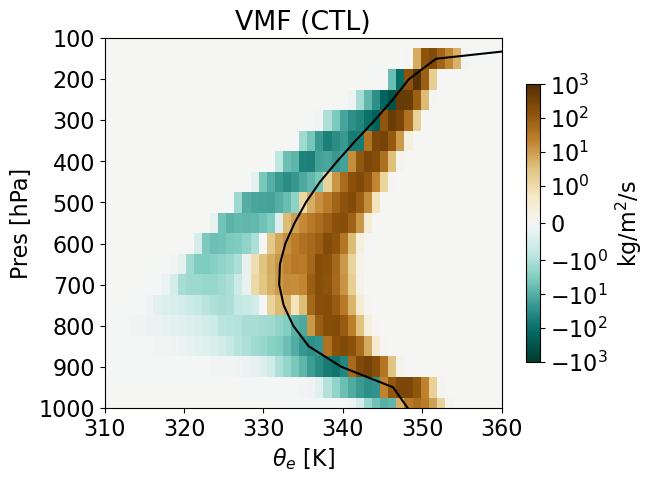

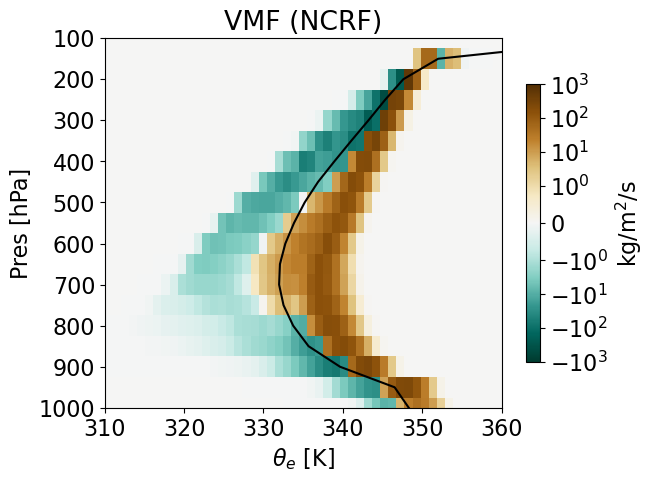

In [131]:
# Plot each test

# for ktest in range(ntest):
for ktest in range(0,2):

    # Get variables
    str_name='theta_e'
    theta_e = (get_var(allvars[ktest], str_name))
    str_name='w'
    w = (get_var(allvars[ktest], str_name))
    str_name='rho'
    rho = (get_var(allvars[ktest], str_name))
    vmf = w*rho

    ivar_select_x='theta_e'
    ylabel='Pres [hPa]'
    # log_y='log'
    log_y='linear'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, theta_e)

    binned_vars = run_3d_binning(bins_x, ivar_x, theta_e, vmf)

    # plot_binned_freq(bins_x, pres, binned_vars['bin_freq'], binned_vars['theta_e_mean'],
    #                 tests_str[ktest].upper(), xlabel, ylabel, log_x, log_y)
    plot_binned_var(bins_x, pres, binned_vars['vmf_binned'], binned_vars['theta_e_mean'], 'vmf', 'kg/m$^2$/s',
                    tests_str[ktest].upper(), xlabel, ylabel, log_x, log_y,
                    norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3))

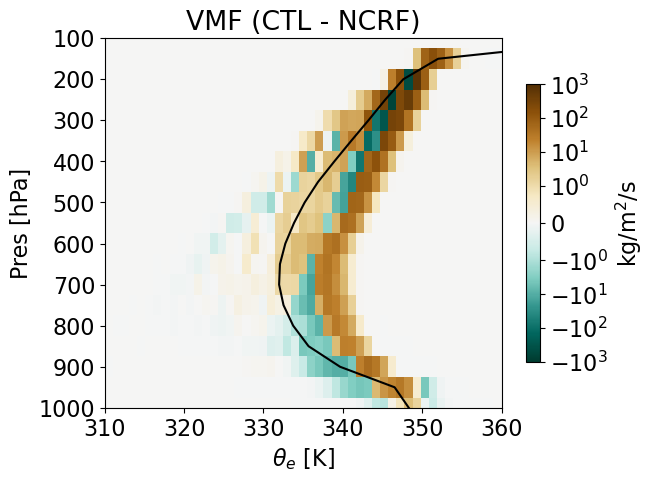

In [129]:
# Differences plots

ktest_ref = 0
str_name='theta_e'
theta_e = (get_var(allvars[ktest_ref], str_name))
str_name='w'
w = (get_var(allvars[ktest_ref], str_name))
str_name='rho'
rho = (get_var(allvars[ktest_ref], str_name))
vmf = w*rho

ivar_select_x='theta_e'
dp = pres[0]-pres[1]
p2 = np.append(pres[range(nz)]+dp/2,pres[nz-1]-dp/2)
ylabel='Pres [hPa]'
log_y='log'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, theta_e)
binned_vars_ref = run_3d_binning(bins_x, ivar_x, theta_e, vmf)

# for ktest in range(1,ntest):
for ktest in range(1,2):

    str_name='theta_e'
    theta_e = (get_var(allvars[ktest], str_name))
    str_name='w'
    w = (get_var(allvars[ktest], str_name))
    str_name='rho'
    rho = (get_var(allvars[ktest], str_name))
    vmf = w*rho

    ivar_select_x='theta_e'
    ylabel='Pres [hPa]'
    log_y='linear'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, theta_e)
    binned_vars = run_3d_binning(bins_x, ivar_x, theta_e, vmf)

    pltvar = binned_vars_ref['vmf_binned'] - binned_vars['vmf_binned']
    test_str = tests_str[ktest_ref].upper()+" - "+tests_str[ktest].upper()
    plot_binned_var(bins_x, pres, pltvar, binned_vars['theta_e_mean'], 'vmf', 'kg/m$^2$/s',
                    test_str, xlabel, ylabel, log_x, log_y,
                    plot_ref=False, the_ref=binned_vars_ref['theta_e_mean'],
                    norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3))

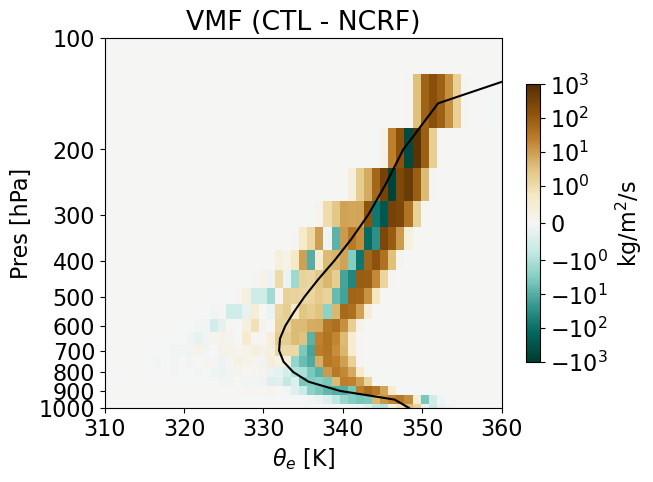

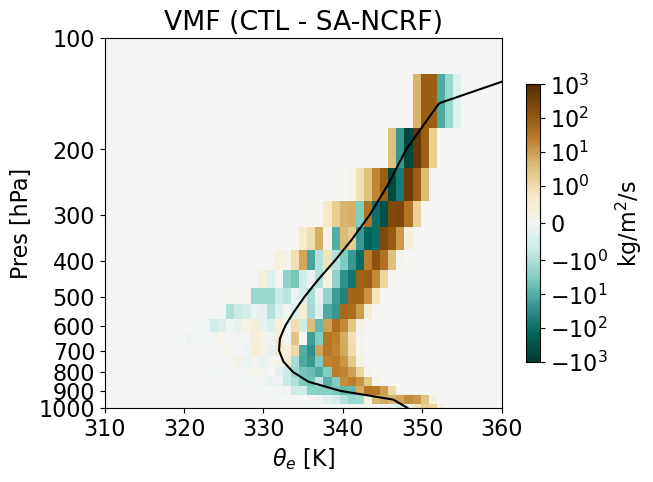

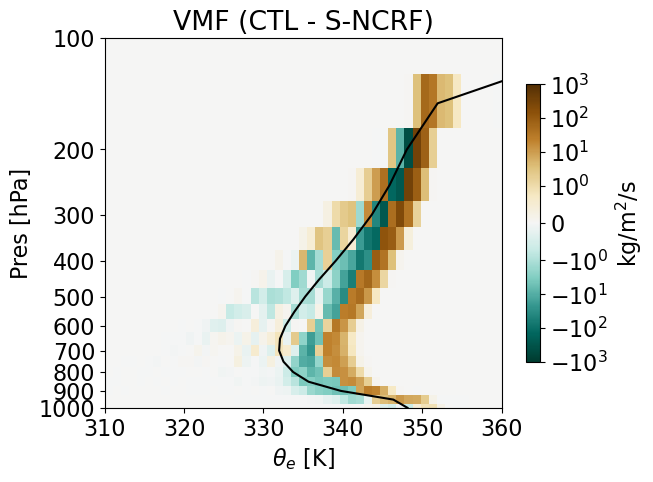

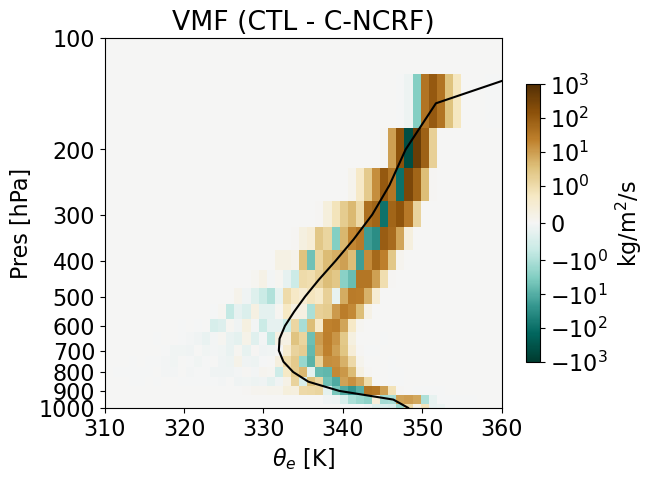

In [133]:
# Differences plots

ktest_ref = 0
str_name='theta_e'
theta_e = (get_var(allvars[ktest_ref], str_name))
str_name='w'
w = (get_var(allvars[ktest_ref], str_name))
str_name='rho'
rho = (get_var(allvars[ktest_ref], str_name))
vmf = w*rho

ivar_select_x='theta_e'
dp = pres[0]-pres[1]
p2 = np.append(pres[range(nz)]+dp/2,pres[nz-1]-dp/2)
ylabel='Pres [hPa]'
log_y='log'

ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, theta_e)
binned_vars_ref = run_3d_binning(bins_x, ivar_x, theta_e, vmf)

for ktest in range(1,ntest):
# for ktest in range(1,2):

    str_name='theta_e'
    theta_e = (get_var(allvars[ktest], str_name))
    str_name='w'
    w = (get_var(allvars[ktest], str_name))
    str_name='rho'
    rho = (get_var(allvars[ktest], str_name))
    vmf = w*rho

    ivar_select_x='theta_e'
    ylabel='Pres [hPa]'
    log_y='log'

    ivar_x, bins_x, bin_axis_x, xlabel, log_x = binvar_settings(ivar_select_x, theta_e)
    binned_vars = run_3d_binning(bins_x, ivar_x, theta_e, vmf)

    pltvar = binned_vars_ref['vmf_binned'] - binned_vars['vmf_binned']
    test_str = tests_str[ktest_ref].upper()+" - "+tests_str[ktest].upper()
    plot_binned_var(bins_x, pres, pltvar, binned_vars['theta_e_mean'], 'vmf', 'kg/m$^2$/s',
                    test_str, xlabel, ylabel, log_x, log_y,
                    norm=colors.SymLogNorm(linthresh=1, linscale=1, vmin=-1e3, vmax=1e3))